## LangGraph 자세히 알아보기
Tool 사용하기

In [1]:
from dotenv import load_dotenv
import os

load_dotenv()

True

In [2]:
from langchain_core.messages import AIMessage
from langchain_core.tools import tool
from langgraph.prebuilt import ToolNode

### 커스텀 Tool 선언

In [3]:
@tool
def get_weather(location: str):
    """Call to get the weather"""
    if location in ["서울", "인천"]:
        return "It's 60 degrees and foggy."
    else:
        return "It's 90 degrees and sunny."
    
    
@tool
def get_coolest_cities():
    """Get a list of cooolest cities"""
    return "서울, 고성"

In [4]:
#Tool Node로 묶어줄 때, 리스트 형태로 tool들을 함께 제공합니다.
tools = [get_weather, get_coolest_cities]
tool_node = ToolNode(tools)

LLM에 도구 연결하기

In [5]:
from langchain_openai import ChatOpenAI


model_with_tools = ChatOpenAI(
    model = "gpt-4o-mini", temperature=0
).bind_tools(tools)

In [6]:
model_with_tools.invoke("서울 날씨는 어때?")

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_DT2NIMEXspCtwA7eoyzG6kO0', 'function': {'arguments': '{"location":"서울"}', 'name': 'get_weather'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 14, 'prompt_tokens': 71, 'total_tokens': 85, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_34a54ae93c', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--8619f471-49b1-4360-b48b-75a4635561d4-0', tool_calls=[{'name': 'get_weather', 'args': {'location': '서울'}, 'id': 'call_DT2NIMEXspCtwA7eoyzG6kO0', 'type': 'tool_call'}], usage_metadata={'input_tokens': 71, 'output_tokens': 14, 'total_tokens': 85, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 

In [7]:
model_with_tools.invoke("서울 날씨는 어때?").tool_calls

[{'name': 'get_weather',
  'args': {'location': '서울'},
  'id': 'call_GtFKIDCaLcbJgrGJMEMZEjnd',
  'type': 'tool_call'}]

In [8]:
model_with_tools.invoke("한국에서 가장 추운 도시는?").tool_calls

[{'name': 'get_coolest_cities',
  'args': {},
  'id': 'call_yY1ikIvN6b3h0zkDtnS3uM8X',
  'type': 'tool_call'}]

도구 노드에다가 llm invoke 결과(도구호출)를 입력해보자.

In [9]:
tool_node.invoke({"messages": [model_with_tools.invoke("서울 날씨는 어때?")]})

{'messages': [ToolMessage(content="It's 60 degrees and foggy.", name='get_weather', tool_call_id='call_1ureudrAov1B9fuCNfSdHRz1')]}

### 노드, 엣지를 선언하고 그래프 정의하기

In [10]:
from typing import Annotated, Literal, TypedDict
from langchain_core.messages import HumanMessage
from langchain_core.tools import tool
from langgraph.graph import StateGraph, START, END, MessagesState

In [11]:
def should_continue(state: MessagesState) -> Literal["tools", END]:
    messages = state['messages']
    last_message = messages[-1]
    if last_message.tool_calls:
        return "tools"
    return END

In [12]:
def call_model(state: MessagesState):
    messages = state['messages']
    response = model_with_tools.invoke(messages)
    return {"messages": [response]}


In [13]:
workflow = StateGraph(MessagesState)

workflow.add_node("agent", call_model)
workflow.add_node("tools", tool_node)


workflow.add_edge(START, "agent")

# add_conditional_edges는 조건부 엣지 추가 함수입니다.
#아래 conditional_edge는 should_continue라는 함수에 따라 agent 노드에서 tool 혹은 end로 진입시킵니다.
# def should_continue(state: MessagesState) -> Literal["tools", END]:
#     messages = state['messages']
#     last_message = messages[-1]
#     # If the LLM makes a tool call, then we route to the "tools" node
#     if last_message.tool_calls:
#         return "tools"
#     # Otherwise, we stop (reply to the user)
#     return END

workflow.add_conditional_edges(
    "agent",
    should_continue,
)

workflow.add_edge("tools", 'agent')

app = workflow.compile()

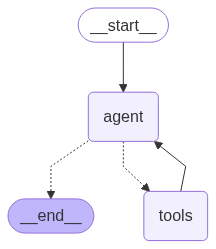

In [14]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

invoke 함수로 호출해보기

In [15]:
final_state = app.invoke(
    {"messages": [HumanMessage(content="서울의 날씨는 어때?")]}
)
final_state["messages"][-1].content

'서울의 날씨는 60도(약 15도)이며 안개가 낀 상태입니다.'

In [16]:
# example with a multiple tool calls in succession

for chunk in app.stream(
    {"messages": [("human", "가장 추운 도시의 날씨는 어때?")]},
    stream_mode="values",
):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

가장 추운 도시의 날씨는 어때?
================================== Ai Message ==================================
Tool Calls:
  get_coolest_cities (call_U3s7alAdLBufB8r8HfNbxJwE)
 Call ID: call_U3s7alAdLBufB8r8HfNbxJwE
  Args:
================================= Tool Message =================================
Name: get_coolest_cities

서울, 고성
================================== Ai Message ==================================
Tool Calls:
  get_weather (call_qaLlhqkt8HtJQWXHiD2OsJEf)
 Call ID: call_qaLlhqkt8HtJQWXHiD2OsJEf
  Args:
    location: 서울
  get_weather (call_MBSE34eVxeeNbngxMEMfqoUH)
 Call ID: call_MBSE34eVxeeNbngxMEMfqoUH
  Args:
    location: 고성
================================= Tool Message =================================
Name: get_weather

It's 90 degrees and sunny.
================================== Ai Message ==================================

가장 추운 도시인 서울의 날씨는 60도(섭씨 약 15도)로 안개가 끼어 있습니다. 반면, 고성의 날씨는 90도(섭씨 약 3